In [1]:
%pylab inline
import timeit
import pandas as pd
import json
import numpy

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding
from keras import backend as K
from keras.layers import merge
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
def get_tokenizer(data):
    
    tokenizer = Tokenizer(lower = True, char_level=False)   
    question_list = data.loc[:,'wordlist_1_clean'].values.tolist()
    question_list += data.loc[:,'wordlist_2_clean'].values.tolist()
    
    question_list = [i.encode('ascii', 'ignore') for i in question_list]
    tokenizer.fit_on_texts(question_list)
    
    word_list = tokenizer.word_index.keys()
    
    f = open('wordlist_clean_embedding.txt', 'w')
    for item in word_list:
        f.write("%s\n" % item)
    f.close()
    
    print('length of the word_list = ',len(word_list))

    return tokenizer

def get_embedding_matrix(wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM):
    
    f = open(wordlist_file, 'r')
    word_list = f.readlines()
    f.close()
    word_list = list(set(word_list))
    print('checking the length of the word_list = ',len(word_list))
    
    
    if EMBEDDING_TYPE == 'word2vec':
        print('Indexing word vectors using word2vec...')     
        EMBEDDING_FILE = '../word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin'
        word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
        vocab_list = word2vec.vocab
        model = word2vec.word_vec
        print('Found %s word vectors of word2vec' % len(vocab_list))
        
    elif EMBEDDING_TYPE == 'glove':
        print('Indexing word vectors using glove.6B...')  
        EMBEDDING_FILE = '../glove.6B/glove.6B.300d.txt'
        embeddings_index = {}
        f = open(EMBEDDING_FILE)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        vocab_list = embeddings_index.keys()
        model = embeddings_index.get
        print('Found %s word vectors of glove.6B' % len(vocab_list))
    
    embedding_matrix = np.zeros((len(word_list)+1, EMBEDDING_DIM))
    absent_words = []
    for i in range(len(word_list)):
        word = word_list[i].strip('\n')
        if word in vocab_list:
            embedding_matrix[i] = model(word)
        else:
            absent_words.append(word)
            
    print('number of null word embeddings in the embedding matrix = ',len(absent_words))
            
    np.savetxt(wordlist_file.strip('.txt')+'_embedding_'+EMBEDDING_TYPE+'.txt', embedding_matrix, delimiter = ',')
      
def get_data_inputs(n,MAX_SEQUENCE_LENGTH,start_index):

    data = pd.read_csv('../input/data_clean.csv', usecols = ['wordlist_1_clean','wordlist_2_clean','is_duplicate'])
    data = data.fillna('')    
    data = data.loc[start_index:start_index+int(n*1.3)] #head(n = int(n*1.3))
    print('data.describe() = ',data.describe())
    print('min and max index = ',min(data.index),max(data.index))
    
    wordlist_1 = np.asarray(data.loc[:,'wordlist_1_clean'].values)
    wordlist_2 = np.asarray(data.loc[:,'wordlist_2_clean'].values)
    labels = np.array(data.loc[:,'is_duplicate'].values)
    
    tokenizer = get_tokenizer(data)

    sequences_1 = tokenizer.texts_to_sequences(wordlist_1)
    sequences_2 = tokenizer.texts_to_sequences(wordlist_2)

    data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
    data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
    

    test_data_1 = data_1[n:,:]
    data_1 = data_1[:n,:]
    test_data_2 = data_2[n:,:]
    data_2 = data_2[:n,:]
    test_labels = labels[n:]
    labels = labels[:n]
    
    print('shape of test_data_1 =',shape(test_data_1))
    
    return data_1,data_2,labels,test_data_1,test_data_2,test_labels 

def split_validation_data(data_1,data_2,labels,VALIDATION_SPLIT):

    
    np.random.seed(np.random.randint(0, 1750))
    perm = np.random.permutation(len(data_1))
    idx_train = perm[:int(len(data_1)*(1-VALIDATION_SPLIT))]
    idx_val = perm[int(len(data_1)*(1-VALIDATION_SPLIT)):]

    data_1_train = np.vstack((data_1[idx_train], data_2[idx_train]))
    data_2_train = np.vstack((data_2[idx_train], data_1[idx_train]))
    labels_train = np.concatenate((labels[idx_train], labels[idx_train]))

    data_1_val = np.vstack((data_1[idx_val], data_2[idx_val]))
    data_2_val = np.vstack((data_2[idx_val], data_1[idx_val]))
    labels_val = np.concatenate((labels[idx_val], labels[idx_val]))
    
    input_train = [data_1_train, data_2_train]
    input_val = [data_1_val, data_2_val]
    
    return input_train,labels_train,input_val,labels_val

def rnn_models(input_train,labels_train,input_val,labels_val,test_data_1,test_data_2,test_labels,wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,rnn_type):
    
    embedding_matrix = []
    f = open(wordlist_file.strip('.txt')+'_embedding_'+EMBEDDING_TYPE+'.txt', 'r')
    for line in f:
        embedding_matrix.append([float(i) for i in line.split(',')])
    f.close()
    embedding_matrix = numpy.asarray(embedding_matrix)
    nb_words = shape(embedding_matrix)[0]

    class_weight = None
    epochs=200
    batch_size=512
    shuffle=True
    
    embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)
    
    if rnn_type == 'GRU':
        num_rnn = 90 
        rate_drop_rnn = 0.2 
        rnn_layer = GRU(num_rnn, dropout=rate_drop_rnn, recurrent_dropout=rate_drop_rnn)

    else:
        num_rnn = 70 
        rate_drop_rnn = 0.2 
        rnn_layer = LSTM(num_rnn, dropout=rate_drop_rnn, recurrent_dropout=rate_drop_rnn)

    STAMP = '%s_%d_%.2f'%(rnn_type,num_rnn,rate_drop_rnn)
    print('drop rate = ',rate_drop_rnn)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    print(type(sequence_1_input))
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = rnn_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = rnn_layer(embedded_sequences_2)

    #https://sorenbouma.github.io/blog/oneshot/
    L1_distance = lambda x: K.abs(x[0]-x[1])
    merged = merge([x1,y1], mode = L1_distance, output_shape=lambda x: x[0])  
    
    preds = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
    
    model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])
    model.summary()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    bst_model_path = STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path,monitor='val_loss', save_best_only=True, save_weights_only=True)

    hist = model.fit(input_train, labels_train, validation_data=(input_val, labels_val), \
        epochs=epochs, batch_size=batch_size, shuffle=shuffle, callbacks=[early_stopping,model_checkpoint])

    model.load_weights(bst_model_path)
    bst_val_score = min(hist.history['val_loss'])
    print('Score = %.4f_'%(bst_val_score))
    
    pyplot.figure()
    pyplot.plot(hist.history['loss'],label = 'loss')
    pyplot.plot(hist.history['val_loss'],label = 'val_loss')
    pyplot.xlabel('epoch')
    pyplot.ylabel('loss/val_loss')
    pyplot.legend()
    pyplot.show()
    
    pyplot.figure()
    pyplot.plot(hist.history['acc'],label = 'acc')
    pyplot.plot(hist.history['val_acc'],label = 'val_acc')
    pyplot.xlabel('epoch')
    pyplot.ylabel('acc/val_acc')
    pyplot.legend()
    pyplot.show()

    preds = model.predict([test_data_1, test_data_2], batch_size=batch_size, verbose=1)
    preds += model.predict([test_data_2, test_data_1], batch_size=batch_size, verbose=1)
    preds /= 2
       
    Y_preds = np.round(preds)
    Y_preds_proba = preds    
    print('max and min value of predicted Y values = ',max(Y_preds),min(Y_preds))    

    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, Y_preds)))
    print("Final Log-loss on the testing data: {:.4f}".format(log_loss(test_labels, Y_preds_proba)))      
    

('data.describe() = ',        is_duplicate
count  65001.000000
mean       0.371640
std        0.483247
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000)
('min and max index = ', 290000, 355000)
('length of the word_list = ', 37651)
('shape of test_data_1 =', (15001, 300))
('checking the length of the word_list = ', 37651)
Indexing word vectors using glove.6B...
Found 400000 word vectors of glove.6B
('number of null word embeddings in the embedding matrix = ', 5781)
('drop rate = ', 0.2)
<class 'tensorflow.python.framework.ops.Tensor'>


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:164: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300)           0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 300)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 300, 300)      11295600    input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 70)            103880      embedding_1[0][0]       

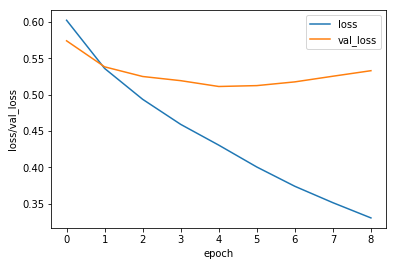

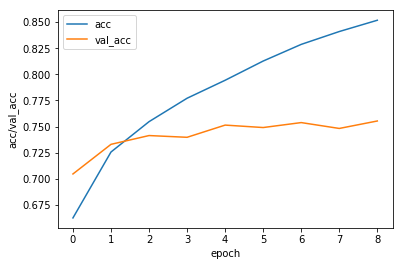

15001/15001 [==============================] - 11s    
('max and min value of predicted Y values = ', array([ 1.], dtype=float32), array([ 0.], dtype=float32))

Optimized Model
------
Final accuracy score on the testing data: 0.7486
Final Log-loss on the testing data: 0.5075


In [3]:
def main(n = 1000, start_index = 0):
    
    
    EMBEDDING_DIM = 300
    MAX_SEQUENCE_LENGTH = 300
    VALIDATION_SPLIT = 0.3
    
    
    data_1,data_2,labels,test_data_1,test_data_2,test_labels = get_data_inputs(n,MAX_SEQUENCE_LENGTH,start_index)
    
    input_train,labels_train,input_val,labels_val = split_validation_data(data_1,data_2,labels,VALIDATION_SPLIT)
    
    EMBEDDING_TYPE = 'glove'
    wordlist_file = 'wordlist_clean_embedding.txt'
    get_embedding_matrix(wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM)
        
    rnn_type = 'LSTM'
    rnn_models(input_train,labels_train,input_val,labels_val,test_data_1,test_data_2,test_labels,wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,rnn_type)

    if 0:
        rnn_type = 'GRU'
        rnn_models(input_train,labels_train,input_val,labels_val,test_data_1,test_data_2,test_labels,wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,rnn_type)

    if 0:
        EMBEDDING_TYPE = 'word2vec'
        wordlist_file = 'wordlist_clean_embedding.txt'
        get_embedding_matrix(wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM)

        
        rnn_type = 'LSTM'
        rnn_models(input_train,labels_train,input_val,labels_val,test_data_1,test_data_2,test_labels,wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,rnn_type)
 
        rnn_type = 'GRU'
        rnn_models(input_train,labels_train,input_val,labels_val,test_data_1,test_data_2,test_labels,wordlist_file,EMBEDDING_TYPE,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,rnn_type)
    
    
main(n = 50000,start_index = 290000)